In [2]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import google_conf
import pickle
import numpy as np

from gensim.matutils import corpus2csc
from gensim.corpora import Dictionary
from gensim.models import Word2Vec
from gensim.models.fasttext import FastText

In [3]:
# point out to your google service account and a google sheet URL to which you wish to send your data
theos_data = google_conf.setup(sheet_url="https://docs.google.com/spreadsheets/d/19gfECdrg5rDiU2PhNYL1nKifeKzemCfYtYrAHQX5vXE/edit?usp=sharing", service_account_path="../../ServiceAccountsKey.json")

In [4]:
# global parameters for plots
#plt.style.use("fast")
plt.style.use("seaborn-v0_8-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

def save_figure(fig, fig_name):
    #each figure to be saved in four different versions
    fig.savefig("../figures/" + fig_name + ".tiff")
    fig.savefig("../figures/" + fig_name + ".png")

In [5]:
LAGT = pd.read_parquet("../data/large_data/LAGT_theos.parquet")

# Frequencies

In [6]:
centuries = [(str(int(n / -100)) + "BCE",  n, n+ 99) for n in range(-800, 0, 100)] + [(str(int(n / 100)) + "CE",  n - 99, n) for n in range(100, 700, 100)]
centuries

[('8BCE', -800, -701),
 ('7BCE', -700, -601),
 ('6BCE', -600, -501),
 ('5BCE', -500, -401),
 ('4BCE', -400, -301),
 ('3BCE', -300, -201),
 ('2BCE', -200, -101),
 ('1BCE', -100, -1),
 ('1CE', 1, 100),
 ('2CE', 101, 200),
 ('3CE', 201, 300),
 ('4CE', 301, 400),
 ('5CE', 401, 500),
 ('6CE', 501, 600)]

In [7]:
with open("../data/subcorpora_ids_dict.pickle", "rb") as f:
    subcorpora_ids_dict= pickle.load(f)

In [8]:
religion_final = ["θεός", "Ζεύς", "εὐσεβής", 'ἱερός']
morality_final = ["ἀγαθός", "ἀρετή", "δίκαιος", "τιμή"]

In [9]:
centuries_targets = []
for cent in centuries:
    century_data = {}
    century_data["cent"] = cent
    LAGT_subset = LAGT[LAGT["cents"].apply(lambda x: cent[0] in x)]
    works_lemmata = LAGT_subset["lemmatized_sentences"].apply(lambda x: [l for s in x for l in s])
    subset_lemmata = [l for work in works_lemmata for l in work]
    subset_wordcount = LAGT_subset["wordcount"].sum()
    for target in religion_final + morality_final:
        target_n = subset_lemmata.count(target)
        century_data[target + "_n"] = target_n
        century_data[target + "_freq"] = target_n / subset_wordcount
    centuries_targets.append(century_data)

centuries_targets_df = pd.DataFrame(centuries_targets)
centuries_targets_df

,cent,θεός_n,θεός_freq,Ζεύς_n,Ζεύς_freq,εὐσεβής_n,εὐσεβής_freq,ἱερός_n,ἱερός_freq,ἀγαθός_n,ἀγαθός_freq,ἀρετή_n,ἀρετή_freq,δίκαιος_n,δίκαιος_freq,τιμή_n,τιμή_freq
0,"(8BCE, -800, -701)",897,0.004117,850,0.003902,0,0.000000,100,0.000459,141,0.000647,41,0.000188,25,0.000115,59,0.000271
1,"(7BCE, -700, -601)",185,0.006708,212,0.007688,0,0.000000,26,0.000943,22,0.000798,4,0.000145,11,0.000399,34,0.001233
2,"(6BCE, -600, -501)",570,0.004711,450,0.003719,12,0.000099,33,0.000273,117,0.000967,68,0.000562,56,0.000463,74,0.000612
3,"(5BCE, -500, -401)",4590,0.002015,2249,0.000987,94,0.000041,846,0.000371,5919,0.002598,1205,0.000529,1900,0.000834,497,0.000218
4,"(4BCE, -400, -301)",3591,0.001043,1784,0.000518,61,0.000018,616,0.000179,8606,0.002499,2148,0.000624,3110,0.000903,716,0.000208
5,"(3BCE, -300, -201)",4662,0.002082,357,0.000159,40,0.000018,266,0.000119,1428,0.000638,498,0.000222,686,0.000306,213,0.000095
6,"(2BCE, -200, -101)",4519,0.003012,96,0.000064,42,0.000028,179,0.000119,802,0.000535,108,0.000072,591,0.000394,180,0.000120
7,"(1BCE, -100, -1)",5062,0.002734,548,0.000296,83,0.000045,1226,0.000662,2911,0.001572,1793,0.000969,918,0.000496,795,0.000429
8,"(1CE, 1, 100)",11581,0.002651,1112,0.000255,138,0.000032,1888,0.000432,5564,0.001274,2525,0.000578,1792,0.000410,1698,0.000389
9,"(2CE, 101, 200)",22374,0.001895,4295,0.000364,244,0.000021,2408,0.000204,15968,0.001353,4000,0.000339,3749,0.000318,1979,0.000168


In [10]:
centuries_targets_df["cents_mid"] = centuries_targets_df["cent"].apply(lambda x: int((x[1] + x[2]) / 2))
centuries_targets_df.set_index("cents_mid", inplace=True)
centuries_targets_df["cent_label"] = centuries_targets_df["cent"].apply(lambda x: x[0])
centuries_targets_df

,cent,θεός_n,θεός_freq,Ζεύς_n,Ζεύς_freq,εὐσεβής_n,εὐσεβής_freq,ἱερός_n,ἱερός_freq,ἀγαθός_n,ἀγαθός_freq,ἀρετή_n,ἀρετή_freq,δίκαιος_n,δίκαιος_freq,τιμή_n,τιμή_freq,cent_label
cents_mid,,,,,,,,,,,,,,,,,,
-750,"(8BCE, -800, -701)",897,0.004117,850,0.003902,0,0.000000,100,0.000459,141,0.000647,41,0.000188,25,0.000115,59,0.000271,8BCE
-650,"(7BCE, -700, -601)",185,0.006708,212,0.007688,0,0.000000,26,0.000943,22,0.000798,4,0.000145,11,0.000399,34,0.001233,7BCE
-550,"(6BCE, -600, -501)",570,0.004711,450,0.003719,12,0.000099,33,0.000273,117,0.000967,68,0.000562,56,0.000463,74,0.000612,6BCE
-450,"(5BCE, -500, -401)",4590,0.002015,2249,0.000987,94,0.000041,846,0.000371,5919,0.002598,1205,0.000529,1900,0.000834,497,0.000218,5BCE
-350,"(4BCE, -400, -301)",3591,0.001043,1784,0.000518,61,0.000018,616,0.000179,8606,0.002499,2148,0.000624,3110,0.000903,716,0.000208,4BCE
-250,"(3BCE, -300, -201)",4662,0.002082,357,0.000159,40,0.000018,266,0.000119,1428,0.000638,498,0.000222,686,0.000306,213,0.000095,3BCE
-150,"(2BCE, -200, -101)",4519,0.003012,96,0.000064,42,0.000028,179,0.000119,802,0.000535,108,0.000072,591,0.000394,180,0.000120,2BCE
-50,"(1BCE, -100, -1)",5062,0.002734,548,0.000296,83,0.000045,1226,0.000662,2911,0.001572,1793,0.000969,918,0.000496,795,0.000429,1BCE
50,"(1CE, 1, 100)",11581,0.002651,1112,0.000255,138,0.000032,1888,0.000432,5564,0.001274,2525,0.000578,1792,0.000410,1698,0.000389,1CE


In [11]:
centuries_targets_df

,cent,θεός_n,θεός_freq,Ζεύς_n,Ζεύς_freq,εὐσεβής_n,εὐσεβής_freq,ἱερός_n,ἱερός_freq,ἀγαθός_n,ἀγαθός_freq,ἀρετή_n,ἀρετή_freq,δίκαιος_n,δίκαιος_freq,τιμή_n,τιμή_freq,cent_label
cents_mid,,,,,,,,,,,,,,,,,,
-750,"(8BCE, -800, -701)",897,0.004117,850,0.003902,0,0.000000,100,0.000459,141,0.000647,41,0.000188,25,0.000115,59,0.000271,8BCE
-650,"(7BCE, -700, -601)",185,0.006708,212,0.007688,0,0.000000,26,0.000943,22,0.000798,4,0.000145,11,0.000399,34,0.001233,7BCE
-550,"(6BCE, -600, -501)",570,0.004711,450,0.003719,12,0.000099,33,0.000273,117,0.000967,68,0.000562,56,0.000463,74,0.000612,6BCE
-450,"(5BCE, -500, -401)",4590,0.002015,2249,0.000987,94,0.000041,846,0.000371,5919,0.002598,1205,0.000529,1900,0.000834,497,0.000218,5BCE
-350,"(4BCE, -400, -301)",3591,0.001043,1784,0.000518,61,0.000018,616,0.000179,8606,0.002499,2148,0.000624,3110,0.000903,716,0.000208,4BCE
-250,"(3BCE, -300, -201)",4662,0.002082,357,0.000159,40,0.000018,266,0.000119,1428,0.000638,498,0.000222,686,0.000306,213,0.000095,3BCE
-150,"(2BCE, -200, -101)",4519,0.003012,96,0.000064,42,0.000028,179,0.000119,802,0.000535,108,0.000072,591,0.000394,180,0.000120,2BCE
-50,"(1BCE, -100, -1)",5062,0.002734,548,0.000296,83,0.000045,1226,0.000662,2911,0.001572,1793,0.000969,918,0.000496,795,0.000429,1BCE
50,"(1CE, 1, 100)",11581,0.002651,1112,0.000255,138,0.000032,1888,0.000432,5564,0.001274,2525,0.000578,1792,0.000410,1698,0.000389,1CE


In [12]:
centuries_targets_df.to_csv("../data/centuries_targets.csv")

In [11]:
#google_conf.set_with_dataframe(theos_data.add_worksheet("centuries_targets", 1,1), centuries_targets_df)

In [13]:
colors_list = ["olive"] * 4 + ["chocolate"] * 4

In [14]:
colors = ["darkblue", "darkgreen", "darkred"]
periods_colors = ['lightcyan',
                  'lightgoldenrodyellow',
                  'lavender',
                  'lightgreen',
                  'lightpink']
periods_dict = {  # to avoid overlaps, startdates are postponed by one year, when needed
    "archaic": {"startdate": -800, "enddate": -501},
    "classical": {"startdate": -500, "enddate": -301},
    "hellenistic": {"startdate": -300, "enddate": 0},
    "roman_peak": {"startdate": 1, "enddate": 200},
    "roman_late": {"startdate": 201, "enddate": 600}}

Text(-0.02, 0.5, 'word frequency')

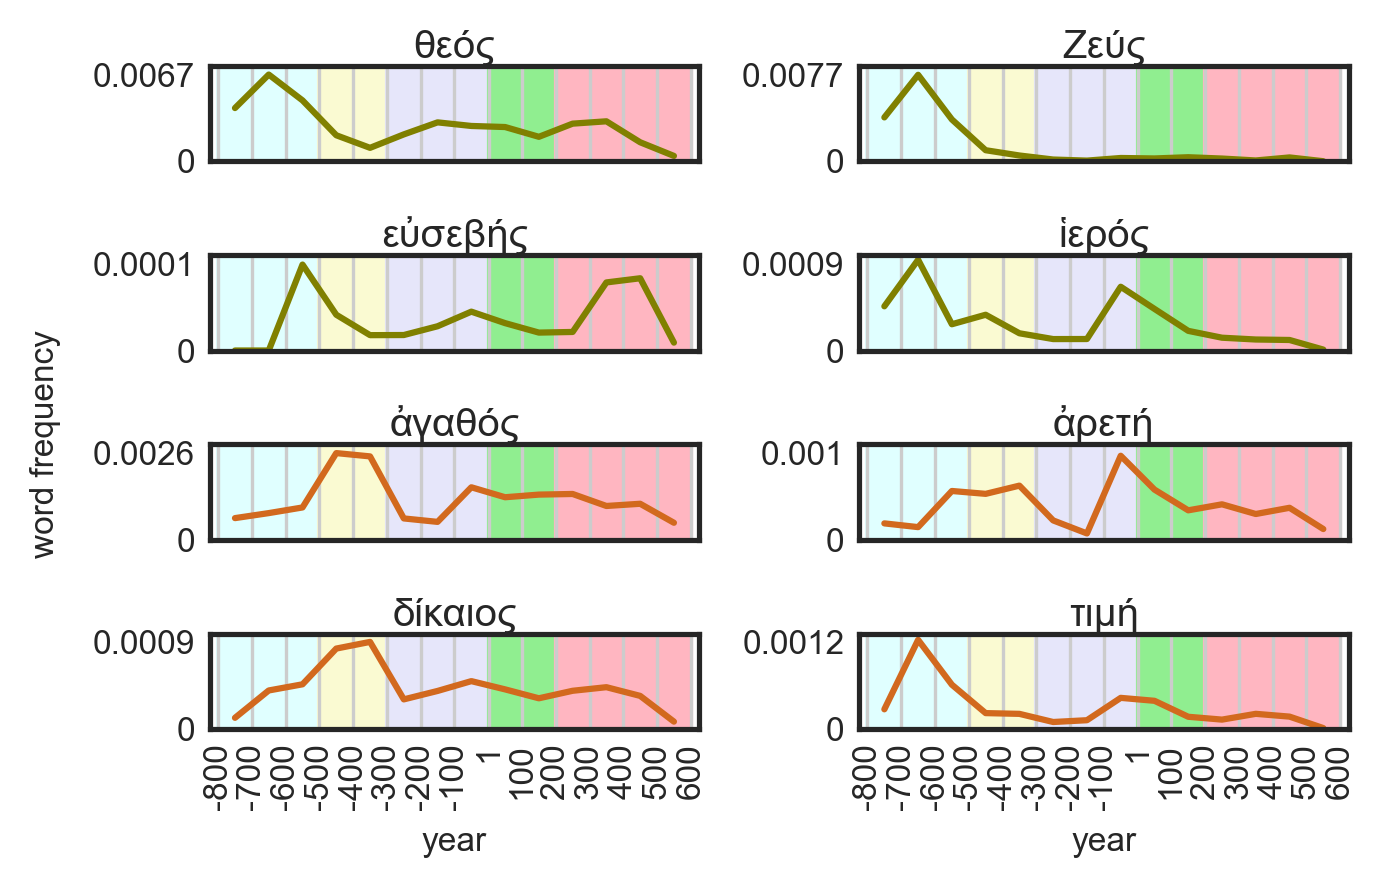

In [15]:
fig, axs = plt.subplots(4,2, figsize=(4.45, 3), tight_layout=True)

for target, ax, color in zip(religion_final + morality_final, axs.ravel(), colors_list):
    for period, color_per in zip(periods_dict.keys(), periods_colors):
        ax.axvspan(periods_dict[period]["startdate"], periods_dict[period]["enddate"], color=color_per, zorder=-1)
    #midpoint = (periods_dict[period]["startdate"] + periods_dict[period]["enddate"]) / 2  # calculate midpoint for label
    #ax.annotate(period, (midpoint, ax.get_ylim()[1] * 0.95), xytext=(0, 10),
    #            textcoords='offset points', ha='center', va='bottom', rotation=90)
    centuries_targets_df[target + "_freq"].plot(ax=ax, color=color)
    y_max = centuries_targets_df[target + "_freq"].max().round(4)
    ax.set_ylim(0, y_max * 1.1)
    ax.set_yticks([int(0), y_max])
    ax.set_yticklabels([str(tick) for tick in [int(0), y_max]])
    ax.set_xlabel("")
    ax.set_xticklabels([])
    #ax.grid(visible=True, axis="y")
    ax.grid(visible=True, axis="x")
    ax.set_title(target, pad=0)
    ax.set_xticks([el+1 if el==0 else el for el in range(-800,700,100)])
    ax.set_xlim(-825,625)


axs[3,0].set_xticklabels([str(el+1) if el==0 else str(el) for el in range(-800,700,100)], rotation=90)
axs[3,1].set_xticklabels([str(el+1) if el==0 else str(el) for el in range(-800,700,100)], rotation=90)

axs[3,0].set_xlabel("year")
axs[3,1].set_xlabel("year")

fig.text(-0.02, 0.5, 'word frequency', va='center', rotation='vertical')

In [16]:
save_figure(fig, "word_frequencies")

In [17]:
centuries_provenience_targets = []
for cent in centuries:
    century_data = {}
    century_data["cent"] = cent
    for provenience in ["pagan", "christian", "jewish"]:
        LAGT_subset = LAGT[(LAGT["cents"].apply(lambda x: cent[0] in x)) & (LAGT["provenience"]==provenience)]
        works_lemmata = LAGT_subset["lemmatized_sentences"].apply(lambda x: [l for s in x for l in s])
        subset_lemmata = [l for work in works_lemmata for l in work]
        subset_wordcount = LAGT_subset["wordcount"].sum()
        for target in religion_final + morality_final:
            target_n = subset_lemmata.count(target)
            century_data[target + "_" + provenience + "_n"] = target_n
            try:
                century_data[target + "_" + provenience + "_freq"] = target_n / subset_wordcount
            except:
                century_data[target + "_" + provenience + "_freq"] = 0
    centuries_provenience_targets.append(century_data)

centuries_provenience_targets_df = pd.DataFrame(centuries_provenience_targets)
centuries_provenience_targets_df

/var/folders/57/tg7c_g894t5c2z3swkqzds5h0000gn/T/ipykernel_8006/847871853.py:14: RuntimeWarning: invalid value encountered in scalar divide
  century_data[target + "_" + provenience + "_freq"] = target_n / subset_wordcount


,cent,θεός_pagan_n,θεός_pagan_freq,Ζεύς_pagan_n,Ζεύς_pagan_freq,εὐσεβής_pagan_n,εὐσεβής_pagan_freq,ἱερός_pagan_n,ἱερός_pagan_freq,ἀγαθός_pagan_n,...,ἱερός_jewish_n,ἱερός_jewish_freq,ἀγαθός_jewish_n,ἀγαθός_jewish_freq,ἀρετή_jewish_n,ἀρετή_jewish_freq,δίκαιος_jewish_n,δίκαιος_jewish_freq,τιμή_jewish_n,τιμή_jewish_freq
0,"(8BCE, -800, -701)",897,0.004117,850,0.003902,0,0.000000,100,0.000459,141,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
1,"(7BCE, -700, -601)",185,0.006708,212,0.007688,0,0.000000,26,0.000943,22,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
2,"(6BCE, -600, -501)",570,0.004711,450,0.003719,12,0.000099,33,0.000273,117,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
3,"(5BCE, -500, -401)",4590,0.002017,2249,0.000988,94,0.000041,846,0.000372,5905,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
4,"(4BCE, -400, -301)",3588,0.001043,1784,0.000518,61,0.000018,616,0.000179,8600,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
5,"(3BCE, -300, -201)",805,0.000590,355,0.000260,7,0.000005,160,0.000117,935,...,106,0.000122,487,0.000558,32,0.000037,415,0.000476,77,0.000088
6,"(2BCE, -200, -101)",645,0.001057,94,0.000154,9,0.000015,73,0.000120,313,...,106,0.000119,489,0.000550,32,0.000036,424,0.000476,79,0.000089
7,"(1BCE, -100, -1)",1968,0.001799,530,0.000484,57,0.000052,924,0.000845,1549,...,302,0.000400,1360,0.001801,958,0.001269,316,0.000419,316,0.000419
8,"(1CE, 1, 100)",3766,0.001333,1034,0.000366,53,0.000019,1015,0.000359,3177,...,790,0.000651,1879,0.001549,1248,0.001029,612,0.000505,682,0.000562
9,"(2CE, 101, 200)",8743,0.000881,3860,0.000389,154,0.000016,2231,0.000225,13518,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN


In [18]:
centuries_provenience_targets_df[['cent', 'ἀρετή_pagan_freq', 'ἀρετή_christian_freq', 'ἀρετή_jewish_freq']]

,cent,ἀρετή_pagan_freq,ἀρετή_christian_freq,ἀρετή_jewish_freq
0,"(8BCE, -800, -701)",0.000188,NaN,NaN
1,"(7BCE, -700, -601)",0.000145,NaN,NaN
2,"(6BCE, -600, -501)",0.000562,NaN,NaN
3,"(5BCE, -500, -401)",0.000527,NaN,NaN
4,"(4BCE, -400, -301)",0.000624,NaN,NaN
5,"(3BCE, -300, -201)",0.000340,NaN,0.000037
6,"(2BCE, -200, -101)",0.000123,NaN,0.000036
7,"(1BCE, -100, -1)",0.000762,NaN,0.001269
8,"(1CE, 1, 100)",0.000446,0.000052,0.001029
9,"(2CE, 101, 200)",0.000307,0.000517,NaN


In [19]:
centuries_provenience_targets_df["cents_mid"] = centuries_provenience_targets_df["cent"].apply(lambda x: int((x[1] + x[2]) / 2))
centuries_provenience_targets_df.set_index("cents_mid", inplace=True)
centuries_provenience_targets_df["cent_label"] = centuries_provenience_targets_df["cent"].apply(lambda x: x[0])

Text(-0.02, 0.5, 'word frequency')

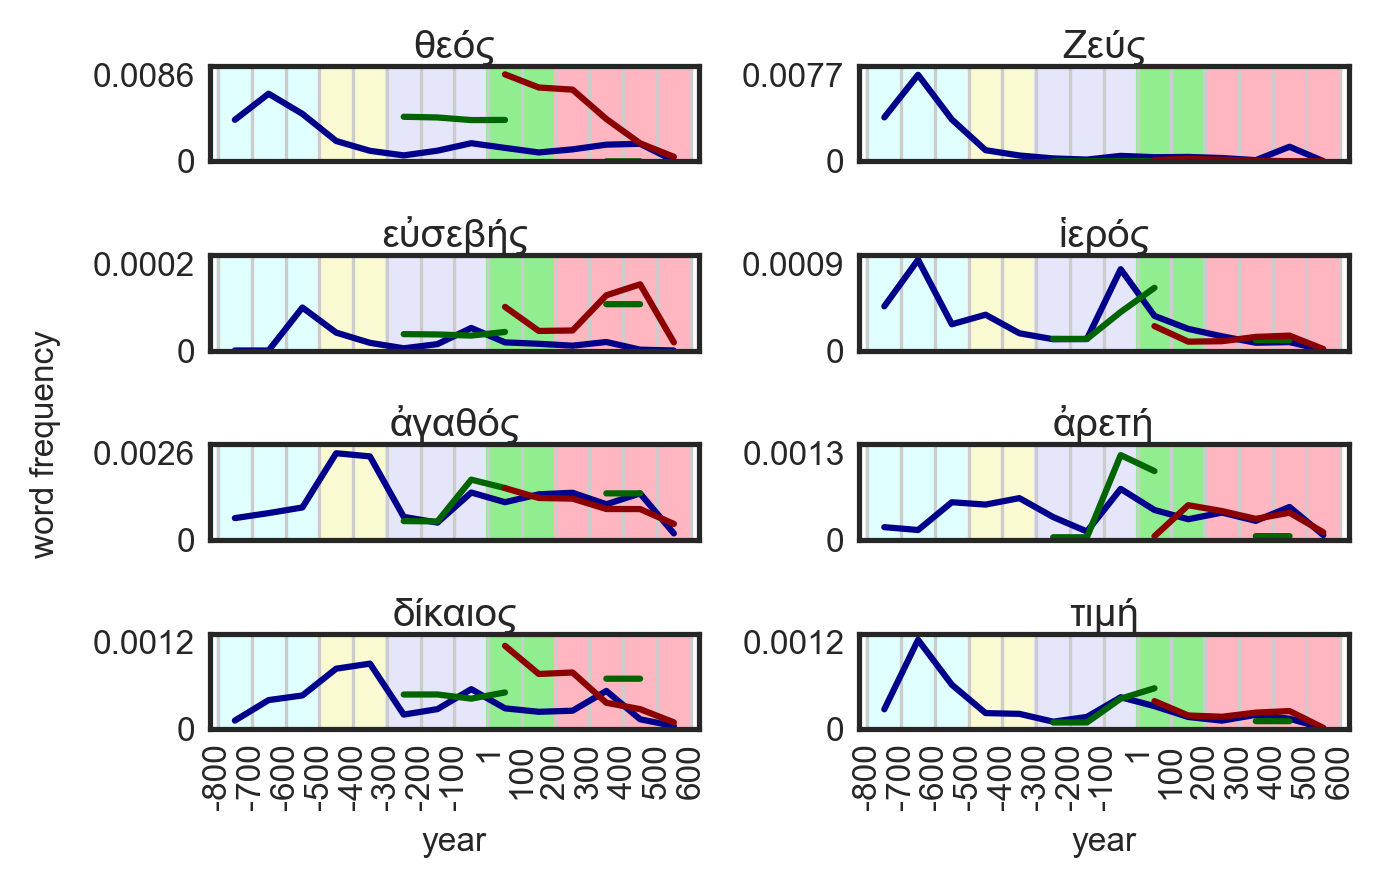

In [20]:
fig, axs = plt.subplots(4,2, figsize=(4.45, 3), tight_layout=True)

for target, ax, color in zip(religion_final + morality_final, axs.ravel(), colors_list):
    for period, color_per in zip(periods_dict.keys(), periods_colors):
        ax.axvspan(periods_dict[period]["startdate"], periods_dict[period]["enddate"], color=color_per, zorder=-1)
    #midpoint = (periods_dict[period]["startdate"] + periods_dict[period]["enddate"]) / 2  # calculate midpoint for label
    #ax.annotate(period, (midpoint, ax.get_ylim()[1] * 0.95), xytext=(0, 10),
    #            textcoords='offset points', ha='center', va='bottom', rotation=90)
    y_maxes = []
    for provenience, prov_color in zip(["pagan", "jewish", "christian"], ["darkblue", "darkgreen", "darkred"]):
        centuries_provenience_targets_df[target + "_" + provenience + "_freq"].plot(ax=ax, color=prov_color)
        y_maxes.append(centuries_provenience_targets_df[target + "_" + provenience + "_freq"].max().round(4))
    y_max = max(y_maxes)
    ax.set_ylim(0, y_max * 1.1)
    ax.set_yticks([int(0), y_max])
    ax.set_yticklabels([str(tick) for tick in [int(0), y_max]])
    ax.set_xlabel("")
    ax.set_xticklabels([])
    #ax.grid(visible=True, axis="y")
    ax.grid(visible=True, axis="x")
    ax.set_title(target, pad=0)
    ax.set_xticks([el+1 if el==0 else el for el in range(-800,700,100)])
    ax.set_xlim(-825,625)


axs[3,0].set_xticklabels([str(el+1) if el==0 else str(el) for el in range(-800,700,100)], rotation=90)
axs[3,1].set_xticklabels([str(el+1) if el==0 else str(el) for el in range(-800,700,100)], rotation=90)

axs[3,0].set_xlabel("year")
axs[3,1].set_xlabel("year")

fig.text(-0.02, 0.5, 'word frequency', va='center', rotation='vertical')

In [21]:
save_figure(fig, "word_frequencies_provenieces")

In [22]:
def freq_in_sents(row, target):
    try:
        target_n = [l for sent in row["lemmatized_sentences"] for l in sent].count(target)
        wordcount = row["wordcount"]
        target_freq = target_n # / wordcount
    except:
        target_n = 0
        target_freq = 0
    return target_n 
    
for target in religion_final + morality_final:
    LAGT[target + "_n"] = LAGT.apply(lambda row: freq_in_sents(row, target), axis=1)

In [23]:
for target in religion_final + morality_final:
    LAGT[target + "_freq"] = LAGT[target + "_n"] / LAGT["wordcount"]

# Cooccurrences

In [24]:
with open("../data/vocabulary_balanced.pickle", "rb") as f:
    vocabulary_balanced = pickle.load(f)

In [25]:
dictionary = Dictionary([vocabulary_balanced])

In [26]:
dictionary.add_documents([["moralindicator"]])

In [27]:
ids_lines = pickle.load(open("../data/ids_lines_wide.pickle", "rb"))

In [28]:
list(ids_lines.items())[:5]

[('ogl0001.ogl001', (0, 25)),
 ('tlg0005.tlg003', (25, 70)),
 ('tlg0006.tlg020', (70, 5712)),
 ('tlg0007.tlg146', (5712, 6527)),
 ('tlg0007.tlg147', (6527, 6587))]

In [31]:
cent = "7BCE"
subcorpus_ids = LAGT[LAGT["cents"].apply(lambda x: cent in x)]["doc_id"].tolist()
len(subcorpus_ids)

34

In [32]:
subcorpus_ids

['tlg0629.tlg001',
 'tlg0013.tlg001',
 'tlg0013.tlg002',
 'tlg0013.tlg003',
 'tlg0013.tlg005',
 'tlg0013.tlg006',
 'tlg0013.tlg008',
 'tlg0013.tlg009',
 'tlg0013.tlg010',
 'tlg0013.tlg011',
 'tlg0013.tlg012',
 'tlg0013.tlg013',
 'tlg0013.tlg014',
 'tlg0013.tlg015',
 'tlg0013.tlg016',
 'tlg0013.tlg017',
 'tlg0013.tlg018',
 'tlg0013.tlg020',
 'tlg0013.tlg021',
 'tlg0013.tlg022',
 'tlg0013.tlg023',
 'tlg0013.tlg024',
 'tlg0013.tlg025',
 'tlg0013.tlg026',
 'tlg0013.tlg027',
 'tlg0013.tlg028',
 'tlg0013.tlg029',
 'tlg0013.tlg030',
 'tlg0013.tlg031',
 'tlg0013.tlg032',
 'tlg0013.tlg033',
 'tlg0020.tlg001',
 'tlg0020.tlg002',
 'tlg0020.tlg003']

In [33]:
cents_sents_ngrams = []
for cent in centuries:
    docs = []
    century_data = {}
    century_data["cent_label"] = cent[0]
    century_data["cent_mid"] = (cent[1] + cent[2]) / 2
    LAGT_subset = LAGT[LAGT["cents"].apply(lambda x: cent[0] in x)]
    n_sents = len([sent for sents in LAGT_subset["lemmatized_sentences"] for sent in sents])
    subcorpus_ids = LAGT_subset["doc_id"].tolist()
    with open("../data/large_data/corpus_ngrams_bydocid_wide.txt", "r") as f:
        lines = f.readlines()
        for id in subcorpus_ids:
            lines_list = [l for l in range(ids_lines[id][0], ids_lines[id][1])]
            for li in lines_list:
                try:
                    line = lines[li]
                    # for line index in subcorpus lineindexes
                    if bool(line.split()):
                        docs.append(line.split())
                except:
                    pass
    cents_sents_ngrams.append({
        "cent" : cent[0], 
        "sents_n" : n_sents,
        "ngrams_n" : len([doc for doc in docs])})

In [34]:
cents_sents_ngrams_df = pd.DataFrame(cents_sents_ngrams)
cents_sents_ngrams_df

,cent,sents_n,ngrams_n
0,8BCE,16465,82595
1,7BCE,2033,11796
2,6BCE,10776,43583
3,5BCE,159843,826817
4,4BCE,227817,1097516
5,3BCE,112579,533468
6,2BCE,64774,357936
7,1BCE,118612,702661
8,1CE,261238,1421351
9,2CE,726607,3469002


In [35]:
def get_sents_ngrams_data(LAGT_subset):
    n_sents = len([sent for sents in LAGT_subset["lemmatized_sentences"] for sent in sents])
    subcorpus_ids = LAGT_subset["doc_id"].tolist()
    with open("../data/large_data/corpus_ngrams_bydocid_wide.txt", "r") as f:
        lines = f.readlines()
    docs = []
    for id in subcorpus_ids:
        lines_list = [l for l in range(ids_lines[id][0], ids_lines[id][1])]
        for li in lines_list:
            try:
                line = lines[li]
                # for line index in subcorpus lineindexes
                if bool(line.split()):
                    docs.append(line.split())
            except:
                pass
    sents_ngrams_data = {
        "sents_n" : n_sents,
        "ngrams_n" : len([doc for doc in docs])}
    return sents_ngrams_data

In [36]:
periods_sents_ngrams = []
for sub in (subcorpora_ids_dict.keys()):
    LAGT_subset = LAGT[LAGT["doc_id"].isin(subcorpora_ids_dict[sub])]
    sents_ngrams_data = get_sents_ngrams_data(LAGT_subset)
    sents_ngrams_data["subcorpus"] = sub
    periods_sents_ngrams.append(sents_ngrams_data)

periods_sents_ngrams_df = pd.DataFrame(periods_sents_ngrams)
periods_sents_ngrams_df

,sents_n,ngrams_n,subcorpus
0,27254,126230,pagan_archaic
1,278422,1354952,pagan_classical
2,158342,902024,pagan_hellenistic
3,654793,3236424,pagan_roman_peak
4,342358,1192527,pagan_roman_late
5,146138,541951,christian_roman_peak
6,258288,958670,christian_roman_late
7,97685,562478,jewish


# Simple co-occurrences within sentences

In [40]:
religionmoral_sents_all = []
religionmoral_cooc_freqs = []
for sub in (subcorpora_ids_dict.keys()):
    religionmoral_info = {"subcorpus" : sub} 
    religionmoral_sents = []
    LAGT_subset = LAGT[LAGT["doc_id"].isin(subcorpora_ids_dict[sub])]
    sents = [sent for sents in LAGT_subset["lemmatized_sentences"] for sent in sents]
    sents_n = len(sents)
    for sent in sents:
        if any(element in sent for element in morality_final) and any(element in sent for element in religion_final):            
            religionmoral_sents.append(sent)
            religionmoral_sents_all.append((sub, list(sent)))
    religionmoral_info["religionmoral_freq"] = len(religionmoral_sents) / sents_n
    religionmoral_cooc_freqs.append(religionmoral_info)

In [41]:
religionmoral_sents_all[:10]

[('pagan_archaic',
  ['βούλομαι',
   'θεός',
   'τιμή',
   'ἄνθρωπος',
   'ἔχω',
   'πᾶς',
   'ἀγαθός',
   'δοτῆρω',
   'κακός',
   'ἀποτρόπους',
   'ὑπάρχω']),
 ('pagan_archaic',
  ['ἐπιγνός',
   'δῶρον',
   'ἄνθρωπος',
   'προσκυνέω',
   'εὐχαριστέω',
   'οἴχομαι',
   'θεός',
   'λόγος',
   'τιμηθέντων',
   'πᾶς',
   'ἔχω',
   'τίς',
   'τιμή',
   'ζηλόω',
   'ἀναίσθης',
   'ἄλογος',
   'ζῷον']),
 ('pagan_archaic',
  ['Ζεύς', 'πίθῳ', 'ἀγαθός', 'συγκλείω', 'ἀφίημι', 'ἄνθρωπος']),
 ('pagan_archaic',
  ['Ζεύς', 'πίθῳ', 'ἀγαθός', 'ἐγκατακλείω', 'ἀφίημι', 'ἄνθρωπος']),
 ('pagan_archaic',
  ['συμβαίνω',
   'ἄνθρωπος',
   'Ζεύς',
   'χρόνος',
   'γίγνομαι',
   'ἀκέραιος',
   'ἀγαθός']),
 ('pagan_archaic',
  ['φημί',
   'πᾶς',
   'διαιρετός',
   'ἀδιαίρετος',
   'γενητός',
   'ἀγένητος',
   'θνητός',
   'ἀθάνατος',
   'λόγος',
   'αἰών',
   'πατήρ',
   'υἱός',
   'θεός',
   'δίκαιος']),
 ('pagan_archaic',
  ['Πηλείδης',
   'ἐθέλω',
   'ἐρίζω',
   'βασιλεύς',
   'ὁμοῖος',
   'μείρομαι',
   'τ

In [42]:
pd.DataFrame(religionmoral_cooc_freqs)

,subcorpus,religionmoral_freq
0,pagan_archaic,0.003559
1,pagan_classical,0.002654
2,pagan_hellenistic,0.002311
3,pagan_roman_peak,0.001564
4,pagan_roman_late,0.001458
5,christian_roman_peak,0.005618
6,christian_roman_late,0.003992
7,jewish,0.007749


In [113]:
class NgramCorpusBows:
    def __iter__(self):
        with open("../data/large_data/corpus_ngrams_bydocid_wide.txt", "r") as f:
            lines = f.readlines()
            for id in subcorpus_ids:
                lines_list = [l for l in range(ids_lines[id][0], ids_lines[id][1])]
                for li in lines_list:
                    try:
                        line = lines[li]
                        # for line index in subcorpus lineindexes
                        if bool(line.split()):
                            doc = line.split()
                            if [element for element in morality_final if element in doc]:
                                doc = doc + ["moralindicator"]
                            bow = dictionary.doc2bow(doc)
                            yield bow
                    except:
                        pass

In [133]:
class NgramCorpusSample(object):
    def __init__(self, ids_list, ids_lines, fname, sample_size=None, sample_seed=1, bow=False, dct=None):
        self.ids_list = ids_list
        self.fname = fname
        self.bow  = bow
        self.dct = dct
        self.sample_size = sample_size
        self.ids_lines = ids_lines
        lines_list = [ ]
        for id in ids_list:
            lines_list.extend([l for l in range(ids_lines[id][0], ids_lines[id][1])])
        ngrams_n = len(lines_list)
        if sample_size != None:
            np.random.seed(sample_seed)
            sample_inx =np.random.randint(0, ngrams_n, sample_size)
        else:
            sample_inx =[n for n in range(0, ngrams_n)]
        sample_lines = np.array(lines_list)[sample_inx]
        self.len = len(sample_lines)
        self.sample_lines = sample_lines
    def __len__(self):
        #[el for el in self]
        return self.len
    def __iter__(self):
        with open(self.fname, "r") as f:
            lines = f.readlines()
            for li in self.sample_lines:
                line = lines[li] # for line index in subcorpus lineindexes
                if bool(line.split()):
                    if (self.bow) & (self.dct != None):
                        yield self.dct.doc2bow(line.split())
                    else:
                        yield line.split()

In [50]:
for cent in centuries:
    century_data = {}
    century_data["cent_label"] = cent[0]
    century_data["cent_mid"] = (cent[1] + cent[2]) / 2
    LAGT_subset = LAGT[LAGT["cents"].apply(lambda x: cent[0] in x)]
    subcorpus_ids = LAGT_subset["doc_id"].tolist()
    corpus = NgramCorpusBows()
    print(cent, len([doc for doc in corpus]))

('8BC', -800, -701) 82600
('7BC', -700, -601) 11800
('6BC', -600, -501) 43596
('5BC', -500, -401) 826914
('4BC', -400, -301) 1099121
('3BC', -300, -201) 561268
('2BC', -200, -101) 358452
('1BC', -100, -1) 702973
('1CE', 1, 100) 1427477
('2CE', 101, 200) 3478436
('3CE', 201, 300) 1318890
('4CE', 301, 400) 953459
('5CE', 401, 500) 503752
('6CE', 501, 600) 745269


In [117]:
cent = "4BC"
subcorpus_ids = LAGT[LAGT["cents"].apply(lambda x: cent in x)]["doc_id"].tolist()
corpus = NgramCorpusBows()
dct_subset = Dictionary.from_corpus(corpus, id2word=dictionary)

In [118]:
term_doc_mat = corpus2csc(corpus, num_terms=len(dct_subset))
vocabulary = list(dct_subset.values())
cooc = np.dot(term_doc_mat, term_doc_mat.T)

In [119]:
len(vocabulary)

5111

In [120]:
cooc.shape

(5111, 5111)

In [121]:
cooc_df = pd.DataFrame(cooc.todense(), index=vocabulary, columns=vocabulary)
cooc_df["θεός"].sort_values(ascending=False)[:20]

θεός              14759.0
εἰμί               3619.0
οὗτος              2752.0
αὐτός              2200.0
τις                1514.0
λέγω               1470.0
πᾶς                1434.0
ἄνθρωπος           1379.0
moralindicator     1188.0
ἄλλος              1018.0
γίγνομαι           1000.0
ποιέω               920.0
ἔχω                 876.0
φημί                830.0
ἀγαθός              815.0
πολύς               805.0
πόλις               599.0
οὐδείς              514.0
δίδωμι              508.0
ἀνήρ                508.0
Name: θεός, dtype: float64

In [122]:
def get_ppmi_df(term_doc_mat, vocabulary):
    cooc = np.dot(term_doc_mat, term_doc_mat.T).toarray()
    total_cooc = cooc.sum()
    prob_A = np.diagonal(cooc) / total_cooc
    prob_B = prob_A
    joint_prob_AB = cooc / total_cooc
    with np.errstate(divide='ignore', invalid='ignore'):
        MI = np.where(np.outer(prob_A, prob_B) != 0, np.log2(joint_prob_AB / np.outer(prob_A, prob_B)), 0)
    MI = np.maximum(MI, 0)  # make the MI matrix as PPMI matrix
    PPMI_matrix_df = pd.DataFrame(MI, columns=vocabulary, index=vocabulary)
    PPMI_matrix_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return PPMI_matrix_df

def normalize(matrix_df):
    # Get the absolute max value
    max_value = matrix_df.abs().max().max()
    # Divide each entry of the matrix by the maximum value
    normalized_matrix = matrix_df / max_value
    return normalized_matrix

In [123]:
mi_matrix = get_ppmi_df(term_doc_mat, vocabulary=vocabulary)

In [124]:
mi_matrix["θεός"].sort_values(ascending=False)[:20]

θεός           11.149329
εἱμαρμένη      11.149329
ἄποινα         11.149329
εὐστέφανος     11.149329
ἐπιείκελος     10.827400
ἀγλαία         10.734291
νόστος         10.341974
Ἑκάεργος       10.341974
ἄσβεστος       10.256244
προσεύχομαι    10.187803
εὐνάω          10.149329
ἕδνον          10.149329
λατρεία        10.149329
μάγος          10.083740
σέβας          10.061866
ἐμπνέω         10.042413
ἐρέσσω          9.997325
ἴλαος           9.979404
ψάμαθος         9.979404
σμερδαλέος      9.926936
Name: θεός, dtype: float64

In [125]:
morality_final

['ἀγαθός', 'ἀρετή', 'δίκαιος', 'τιμή']

In [126]:
mi_matrix["θεός"]["ἀγαθός"]

5.60536208557799

In [127]:
mi_matrix["θεός"]["ἀγαθός"] / mi_matrix.max().max()


0.22422671833757488

In [129]:
mi_matrix["θεός"]["moralindicator"]

5.745950614254781

In [131]:
centuries_targets_mi = []
for cent in centuries:
    century_data = {}
    century_data["cent_label"] = cent[0]
    century_data["cent_mid"] = (cent[1] + cent[2]) / 2
    LAGT_subset = LAGT[LAGT["cents"].apply(lambda x: cent[0] in x)]
    subcorpus_ids = LAGT_subset["doc_id"].tolist()
    corpus = NgramCorpusBows()
    #corpus = [dictionary.doc2bow(sent) for sents in LAGT_subset["lemmatized_sentences"] for sent in sents]
    dct_subset = Dictionary.from_corpus(corpus, id2word=dictionary)
    term_doc_mat = corpus2csc(corpus, num_terms=len(dct_subset))
    vocabulary = list(dct_subset.values())
    mi_matrix = get_ppmi_df(term_doc_mat, vocabulary=vocabulary)
    # normalized_mi_matrix = normalize(mi_matrix)
    for rel_term in religion_final:
        century_data[rel_term + "_moralindicator_mi"] = mi_matrix[rel_term]["moralindicator"] /  mi_matrix[rel_term].max()
        for mor_term in morality_final:
            century_data[rel_term + "_" + mor_term + "_mi"] = mi_matrix[rel_term][mor_term] /  mi_matrix[rel_term].max()
    centuries_targets_mi.append(century_data)

centuries_targets_mi_df = pd.DataFrame(centuries_targets_mi)
centuries_targets_mi_df.set_index("cent_mid", inplace=True)
centuries_targets_mi_df

/var/folders/57/tg7c_g894t5c2z3swkqzds5h0000gn/T/ipykernel_6018/235269415.py:16: RuntimeWarning: invalid value encountered in scalar divide
  century_data[rel_term + "_moralindicator_mi"] = mi_matrix[rel_term]["moralindicator"] /  mi_matrix[rel_term].max()
/var/folders/57/tg7c_g894t5c2z3swkqzds5h0000gn/T/ipykernel_6018/235269415.py:18: RuntimeWarning: invalid value encountered in scalar divide
  century_data[rel_term + "_" + mor_term + "_mi"] = mi_matrix[rel_term][mor_term] /  mi_matrix[rel_term].max()


,cent_label,θεός_moralindicator_mi,θεός_ἀγαθός_mi,θεός_ἀρετή_mi,θεός_δίκαιος_mi,θεός_τιμή_mi,Ζεύς_moralindicator_mi,Ζεύς_ἀγαθός_mi,Ζεύς_ἀρετή_mi,Ζεύς_δίκαιος_mi,...,εὐσεβής_moralindicator_mi,εὐσεβής_ἀγαθός_mi,εὐσεβής_ἀρετή_mi,εὐσεβής_δίκαιος_mi,εὐσεβής_τιμή_mi,ἱερός_moralindicator_mi,ἱερός_ἀγαθός_mi,ἱερός_ἀρετή_mi,ἱερός_δίκαιος_mi,ἱερός_τιμή_mi
cent_mid,,,,,,,,,,,,,,,,,,,,,
-750.5,8BC,0.576626,0.456991,0.602142,0.545385,0.698772,0.593600,0.458808,0.555624,0.597462,...,NaN,NaN,NaN,NaN,NaN,0.213782,0.000000,0.000000,0.000000,0.369719
-650.5,7BC,0.691553,0.598800,0.849483,0.598800,0.742326,0.609127,0.502131,0.000000,0.601945,...,NaN,NaN,NaN,NaN,NaN,0.304280,0.000000,0.000000,0.000000,0.376027
-550.5,6BC,0.573296,0.447989,0.376595,0.593681,0.689368,0.482581,0.469665,0.473948,0.439298,...,0.492103,0.574590,0.000000,0.641890,0.000000,0.450945,0.000000,0.615212,0.000000,0.000000
-450.5,5BC,0.523386,0.508033,0.496566,0.505241,0.627515,0.369421,0.352986,0.353758,0.365458,...,0.382681,0.345746,0.241593,0.505168,0.380557,0.291070,0.243838,0.350274,0.236718,0.427446
-350.5,4BC,0.515363,0.502753,0.479634,0.471147,0.609165,0.368070,0.359399,0.293312,0.359289,...,0.380555,0.306170,0.236486,0.485218,0.383512,0.299642,0.255581,0.241230,0.267001,0.459765
-250.5,3BC,0.560249,0.549725,0.481897,0.596766,0.494007,0.411855,0.396387,0.425098,0.235044,...,0.414990,0.418260,0.000000,0.447562,0.000000,0.315445,0.326756,0.214334,0.173603,0.403060
-150.5,2BC,0.565637,0.563079,0.479606,0.581283,0.482879,0.414933,0.392478,0.475999,0.242033,...,0.425391,0.433368,0.000000,0.310347,0.504345,0.297120,0.310888,0.362791,0.184867,0.297370
-50.5,1BC,0.545033,0.517643,0.493354,0.531817,0.644179,0.345479,0.274017,0.348141,0.308834,...,0.490743,0.324637,0.371741,0.633384,0.515171,0.345953,0.277879,0.287151,0.330733,0.477026
50.5,1CE,0.556253,0.523091,0.523090,0.601194,0.604713,0.350997,0.340264,0.321754,0.324501,...,0.448344,0.366455,0.335289,0.575696,0.431063,0.325345,0.262365,0.296379,0.302858,0.418778


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'year')

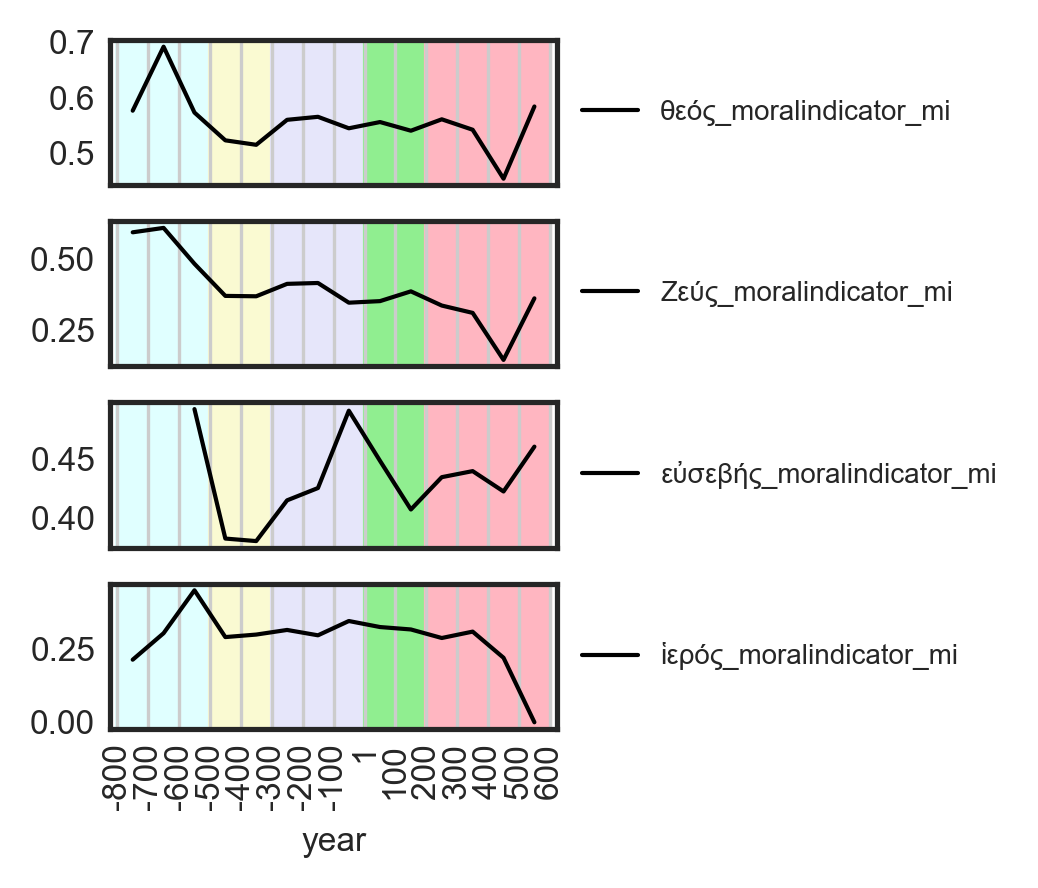

In [132]:
fig, axs = plt.subplots(4,1, figsize=(3.5, 3),tight_layout=True)
linestyles = ['-', '--', '-.', ':']
#linecolors = ['#C0C0C0', '#808080', '#505050', '#000000']
lighter_colors = [
    (0.0, 0.4, 0.4),  # lighter cyan
    (0.0, 0.4, 0.0),  # lighter green
    (0.4, 0.0, 0.4),  # lighter magenta
    (0.0, 0.0, 0.4)  # lighter blue
]

for rel_term, ax in zip(religion_final, axs):
    ax.legend(fontsize="small", loc='center left', bbox_to_anchor=(1, 0.5))
    for period, color_per in zip(periods_dict.keys(), periods_colors):
        ax.axvspan(periods_dict[period]["startdate"], periods_dict[period]["enddate"], color=color_per, zorder=-1)
    centuries_targets_mi_df[rel_term + "_moralindicator_mi"].plot(ax=ax, color="black", linewidth=1)
    #for mor_term, color in zip(morality_final, lighter_colors):
    #    centuries_targets_mi_df[rel_term + "_" + mor_term + "_mi"].plot(ax=ax, color=color, linewidth=1)
    #y_max = centuries_targets_df[target + "_freq"].max().round(4)
    #ax.set_ylim(0, y_max * 1.1)
    #ax.set_yticks([int(0), y_max])
    #ax.set_yticklabels([str(tick) for tick in [int(0), y_max]])
    ax.set_xlabel("")
    ax.set_xticklabels([])
    #ax.grid(visible=True, axis="y")
    ax.grid(visible=True, axis="x")
    #ax.set_title(target, pad=0)
    ax.set_xticks([el+1 if el==0 else el for el in range(-800,700,100)])
    ax.set_xlim(-825,625)
    ax.legend(fontsize="small", loc='center left', bbox_to_anchor=(1, 0.5))

axs[3].set_xticklabels([str(el+1) if el==0 else str(el) for el in range(-800,700,100)], rotation=90)

axs[3].set_xlabel("year")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'year')

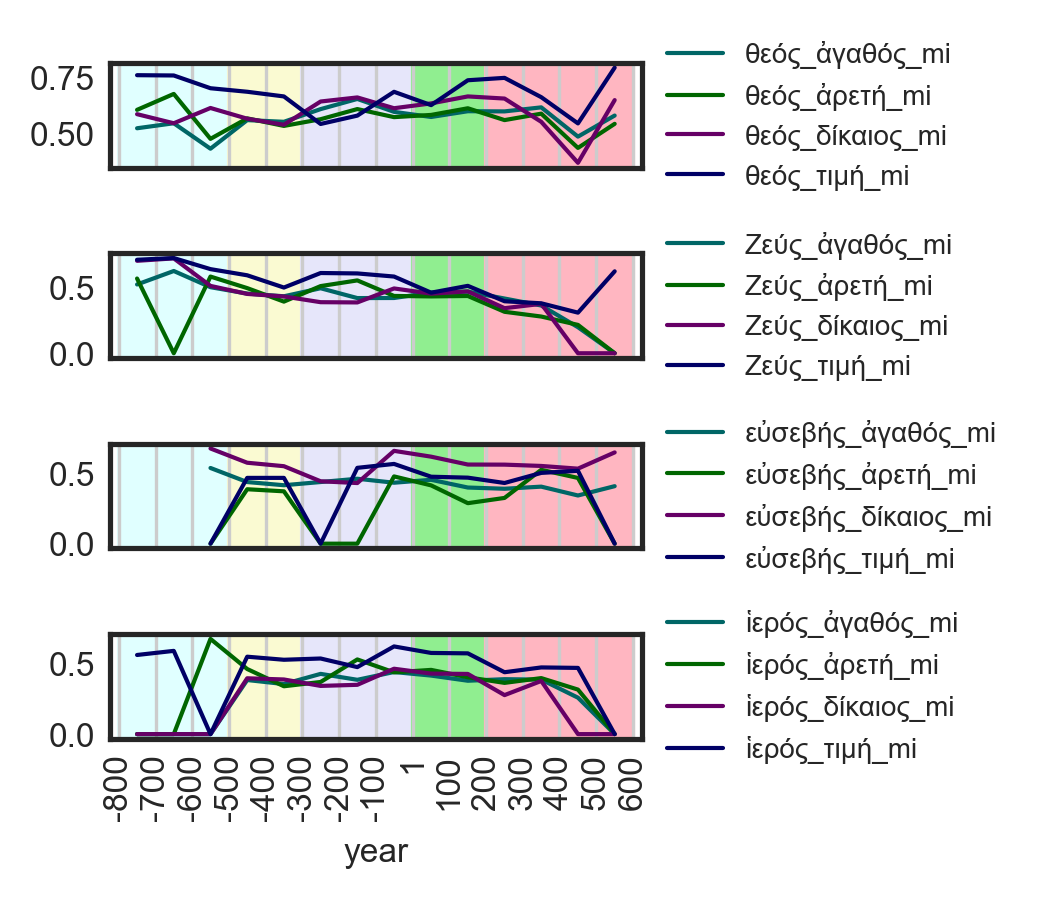

In [103]:
fig, axs = plt.subplots(4,1, figsize=(3.5, 3),tight_layout=True)
linestyles = ['-', '--', '-.', ':']
#linecolors = ['#C0C0C0', '#808080', '#505050', '#000000']
lighter_colors = [
    (0.0, 0.4, 0.4),  # lighter cyan
    (0.0, 0.4, 0.0),  # lighter green
    (0.4, 0.0, 0.4),  # lighter magenta
    (0.0, 0.0, 0.4)  # lighter blue
]

for rel_term, ax in zip(religion_final, axs):
    ax.legend(fontsize="small", loc='center left', bbox_to_anchor=(1, 0.5))
    for period, color_per in zip(periods_dict.keys(), periods_colors):
        ax.axvspan(periods_dict[period]["startdate"], periods_dict[period]["enddate"], color=color_per, zorder=-1)
    for mor_term, color in zip(morality_final, lighter_colors):
        centuries_targets_mi_df[rel_term + "_" + mor_term + "_mi"].plot(ax=ax, color=color, linewidth=1)
    #y_max = centuries_targets_df[target + "_freq"].max().round(4)
    #ax.set_ylim(0, y_max * 1.1)
    #ax.set_yticks([int(0), y_max])
    #ax.set_yticklabels([str(tick) for tick in [int(0), y_max]])
    ax.set_xlabel("")
    ax.set_xticklabels([])
    #ax.grid(visible=True, axis="y")
    ax.grid(visible=True, axis="x")
    #ax.set_title(target, pad=0)
    ax.set_xticks([el+1 if el==0 else el for el in range(-800,700,100)])
    ax.set_xlim(-825,625)
    ax.legend(fontsize="small", loc='center left', bbox_to_anchor=(1, 0.5))

axs[3].set_xticklabels([str(el+1) if el==0 else str(el) for el in range(-800,700,100)], rotation=90)
    
axs[3].set_xlabel("year")

#fig.text(-0.02, 0.5, 'word frequency', va='center', rotation='vertical')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'year')

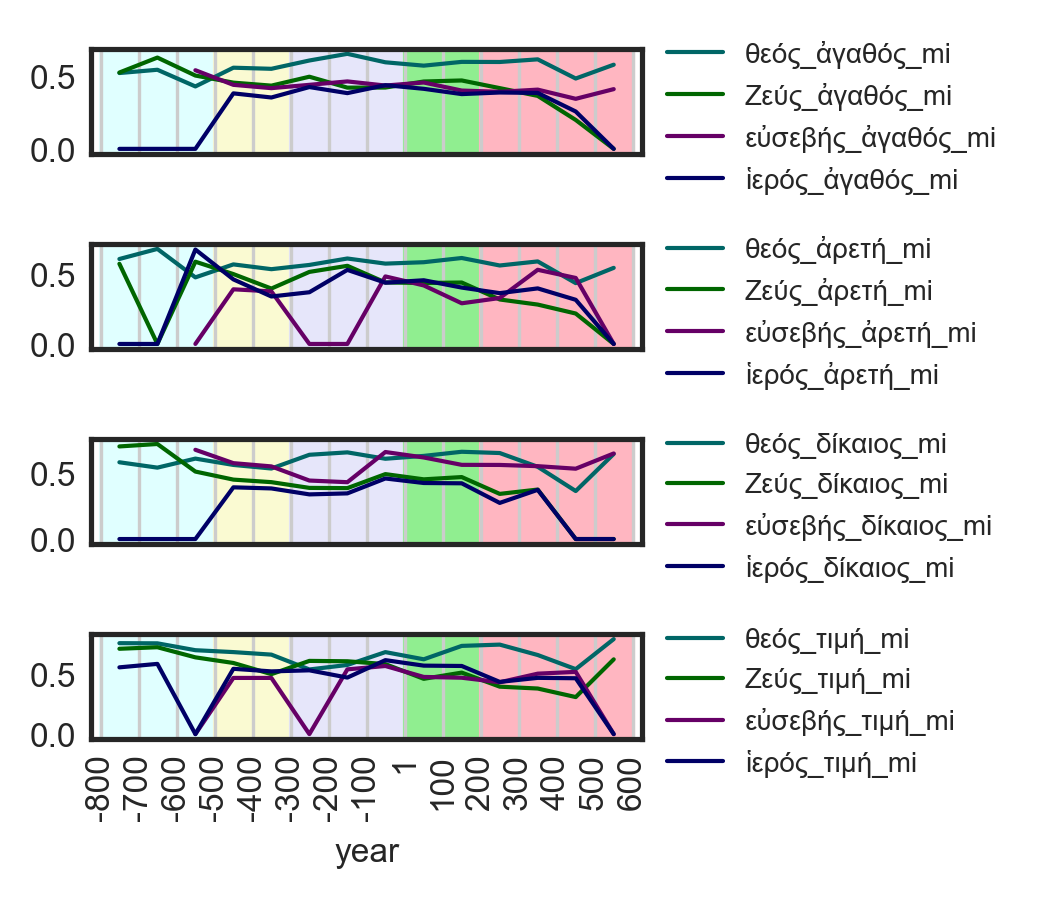

In [104]:
fig, axs = plt.subplots(4,1, figsize=(3.5, 3),tight_layout=True)
linestyles = ['-', '--', '-.', ':']
#linecolors = ['#C0C0C0', '#808080', '#505050', '#000000']
lighter_colors = [
    (0.0, 0.4, 0.4),  # lighter cyan
    (0.0, 0.4, 0.0),  # lighter green
    (0.4, 0.0, 0.4),  # lighter magenta
    (0.0, 0.0, 0.4)  # lighter blue
]

for mor_term, ax in zip(morality_final, axs):
    ax.legend(fontsize="small", loc='center left', bbox_to_anchor=(1, 0.5))
    for period, color_per in zip(periods_dict.keys(), periods_colors):
        ax.axvspan(periods_dict[period]["startdate"], periods_dict[period]["enddate"], color=color_per, zorder=-1)
    for rel_term, color in zip(religion_final, lighter_colors):
        centuries_targets_mi_df[rel_term + "_" + mor_term + "_mi"].plot(ax=ax, color=color, linewidth=1)
    #y_max = centuries_targets_df[target + "_freq"].max().round(4)
    #ax.set_ylim(0, y_max * 1.1)
    #ax.set_yticks([int(0), y_max])
    #ax.set_yticklabels([str(tick) for tick in [int(0), y_max]])
    ax.set_xlabel("")
    ax.set_xticklabels([])
    #ax.grid(visible=True, axis="y")
    ax.grid(visible=True, axis="x")
    #ax.set_title(target, pad=0)
    ax.set_xticks([el+1 if el==0 else el for el in range(-800,700,100)])
    ax.set_xlim(-825,625)
    ax.legend(fontsize="small", loc='center left', bbox_to_anchor=(1, 0.35))

axs[3].set_xticklabels([str(el+1) if el==0 else str(el) for el in range(-800,700,100)], rotation=90)

axs[3].set_xlabel("year")